In [1]:
indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_unique/clonal_shifts/variants_init/donors/donor1/clones/knn_kparam_30/"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_unique/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/clones_ranked/"
cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_unique/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/cells_meta.tsv"
is_mt = False
condition = "inputOnly"


p_thresh = 0.1 
clone_id = "cloneID" # "den_clust"



In [2]:
if condition != "inputOnly" and condition != "noInput":
    raise ValueError("condition needs to be inputOnly or noInput")
suffix = "cultured" if condition == "noInput" else "input"

In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
%load_ext autoreload
%autoreload 2
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

from mplh import cluster_help as ch

from scipy.stats import rankdata, gmean


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
fig_utils from mplh


## Load ncells and save to output. Sort by ncells

In [5]:
ncells_df = pd.read_csv(join(indir, f"{condition}_ncells.csv"),  index_col=0)
ncells_df = ncells_df.groupby(clone_id).sum()[["count"]].sort_values(by="count")[::-1]

ncells_df.columns = [f"{x}_{suffix}" for x in ncells_df.columns]


#ncells_df = pd.merge(input_ncells,ncells_df,left_index=True, right_index=True, suffixes=["_input", "_cultured"])
ncells_df = ncells_df.loc[ncells_df.sum(axis=1).sort_values()[::-1].index]
ncells_df

norm_ncells_df = ncells_df/ncells_df.sum(axis=0)
norm_ncells_df

#norm_ncells_df["fold"] = norm_ncells_df["count_cultured"]/norm_ncells_df["count_input"]


,count_input
cloneID,
1_0,0.121628
1_1,0.089163
1_2,0.072245
1_3,0.064015
1_4,0.052583
...,...
1_86,0.000914
1_73,0.000914
1_70,0.000914


## Load shuffle hypergeometric results for input and cultured
## Convert into long df with cloneID ('index'), clusterID ('variable'), pval, method (hypergeo or one of four shuffle methods), and condition ('input' or 'cultured')

In [6]:
hyper = pd.read_csv(join(indir, "hypergeo_pvals.csv"),  index_col=0)
shuffle_df = pd.read_csv(join(indir, "shuffle_results_pvals.csv"), index_col=0)
shuffle_df = shuffle_df.rename({"value":"pval"}, axis=1)
shuffle_df["condition"] = suffix

hyper_df = hyper.reset_index().melt(id_vars="index", value_name="pval")
hyper_df["method"] = "hypergeo"
hyper_df["condition"] = suffix


#noInput_df = pd.concat((noInput_hyper_df, noInput_shuffle_df), axis=0, ignore_index=True)
#df = pd.concat((input_df, noInput_df), axis=0).reset_index(drop=True)
df = pd.concat((hyper_df, shuffle_df), axis=0, ignore_index=True)

df["variable"] = df["variable"].astype(object).astype(str)


df

,index,variable,pval,method,condition
0,1_0,0,0.307881,hypergeo,input
1,1_1,0,0.983579,hypergeo,input
2,1_10,0,0.501594,hypergeo,input
3,1_11,0,0.977781,hypergeo,input
4,1_12,0,0.869264,hypergeo,input
...,...,...,...,...,...
3445,1_81,9,1.000000,clone_min,input
3446,1_83,9,1.000000,clone_min,input
3447,1_86,9,1.000000,clone_min,input
3448,1_9,9,1.000000,clone_min,input


In [7]:
df["method"].unique()

array(['hypergeo', 'global_all', 'global_min', 'clone_all', 'clone_min'],
      dtype=object)

## Create 'sig score' that merges the hypergeo and the shuffle results. Score 0-4, with 4 the highest

In [8]:
p_df_group, p_df_out = cs.hypergeo_score(df, p_thresh )
p_df_group

# p_df = df.copy()
# p_df["is_sig"] = p_df["pval"]<p_thresh
# p_df

# def check_sig(x):
#     #print(x.head())
#     name, clust, cond = x.name
#     x = x.set_index("method")["is_sig"]
#     assert(x.index.duplicated().sum()==0)
#     sig = 0    
#     if 'hypergeo' not in x.index:
#         return sig
#     if x["hypergeo"]==True:
#         if ("global_all" in x) and x["global_all"]==True:
#             if ("clone_min" in x) and (x["clone_min"]==True):
#                 if ("global_min" in x) and (x["global_min"]==True):
#                     sig = 4    
#                 else:
#                     sig = 3
#             else:
#                 sig = 2
#         else:
#             sig = 1
#     return sig

# p_df = p_df.groupby(["index","variable", "condition"]).apply(check_sig)
# p_df


# # df.loc[(df["method"] == "hypergeo") & (df["condition"] == "input")].pivot(index="index", columns="variable", values="pval")

# # df.loc[(df["method"] == "hypergeo") & (df["condition"] == "cultured")].pivot(index="index", columns="variable", values="pval")

# p_df_out = p_df.reset_index().rename({0:"significant_score"}, axis=1)
# #p_df_out.set_index( )
# p_df_out["cluster_condition"] = p_df_out.apply(lambda x: f'{x["variable"]}_{x["condition"]}', axis=1)


# #p_df_out["clone_condition"] = p_df_out.apply(lambda x: f'{x["index"]}_{x["condition"]}', axis=1)

# p_df_out = p_df_out.pivot(index='index', columns='cluster_condition', values="significant_score").fillna(0)

# p_df_out

(3450, 6)
False
name ('1_0', '0', 'input')
name ('1_0', '1', 'input')
name ('1_0', '2', 'input')
name ('1_0', '3', 'input')
name ('1_0', '4', 'input')
name ('1_0', '5', 'input')
name ('1_0', '6', 'input')
name ('1_0', '7', 'input')
name ('1_0', '8', 'input')
name ('1_0', '9', 'input')
name ('1_1', '0', 'input')
name ('1_1', '1', 'input')
name ('1_1', '2', 'input')
name ('1_1', '3', 'input')
name ('1_1', '4', 'input')
name ('1_1', '5', 'input')
name ('1_1', '6', 'input')
name ('1_1', '7', 'input')
name ('1_1', '8', 'input')
name ('1_1', '9', 'input')
name ('1_10', '0', 'input')
name ('1_10', '1', 'input')
name ('1_10', '2', 'input')
name ('1_10', '3', 'input')
name ('1_10', '4', 'input')
name ('1_10', '5', 'input')
name ('1_10', '6', 'input')
name ('1_10', '7', 'input')
name ('1_10', '8', 'input')
name ('1_10', '9', 'input')
name ('1_11', '0', 'input')
name ('1_11', '1', 'input')
name ('1_11', '2', 'input')
name ('1_11', '3', 'input')
name ('1_11', '4', 'input')
name ('1_11', '5', 'inpu

name ('1_40', '4', 'input')
name ('1_40', '5', 'input')
name ('1_40', '6', 'input')
name ('1_40', '7', 'input')
name ('1_40', '8', 'input')
name ('1_40', '9', 'input')
name ('1_41', '0', 'input')
name ('1_41', '1', 'input')
name ('1_41', '2', 'input')
name ('1_41', '3', 'input')
name ('1_41', '4', 'input')
name ('1_41', '5', 'input')
name ('1_41', '6', 'input')
name ('1_41', '7', 'input')
name ('1_41', '8', 'input')
name ('1_41', '9', 'input')
name ('1_42', '0', 'input')
name ('1_42', '1', 'input')
name ('1_42', '2', 'input')
name ('1_42', '3', 'input')
name ('1_42', '4', 'input')
name ('1_42', '5', 'input')
name ('1_42', '6', 'input')
name ('1_42', '7', 'input')
name ('1_42', '8', 'input')
name ('1_42', '9', 'input')
name ('1_43', '0', 'input')
name ('1_43', '1', 'input')
name ('1_43', '2', 'input')
name ('1_43', '3', 'input')
name ('1_43', '4', 'input')
name ('1_43', '5', 'input')
name ('1_43', '6', 'input')
name ('1_43', '7', 'input')
name ('1_43', '8', 'input')
name ('1_43', '9', '

name ('1_9', '3', 'input')
name ('1_9', '4', 'input')
name ('1_9', '5', 'input')
name ('1_9', '6', 'input')
name ('1_9', '7', 'input')
name ('1_9', '8', 'input')
name ('1_9', '9', 'input')
name ('1_91', '0', 'input')
name ('1_91', '1', 'input')
name ('1_91', '2', 'input')
name ('1_91', '3', 'input')
name ('1_91', '4', 'input')
name ('1_91', '5', 'input')
name ('1_91', '6', 'input')
name ('1_91', '7', 'input')
name ('1_91', '8', 'input')
name ('1_91', '9', 'input')
(690,)


index  variable  condition
1_0    0         input        0
       1         input        0
       2         input        0
       3         input        0
       4         input        0
                             ..
1_91   5         input        0
       6         input        0
       7         input        0
       8         input        0
       9         input        0
Length: 690, dtype: int64

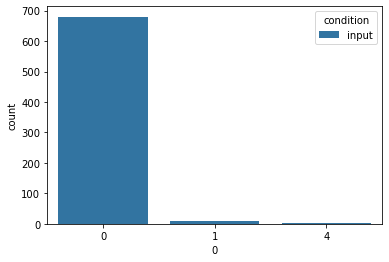

In [9]:
sns.countplot(data=p_df_group.reset_index(), x=0, hue="condition")
plt.savefig(join(outdir, "hypergeo_sig_score_distribution.pdf"))

## Save heatmap for initial hypergeo 

In [10]:
clone_meta = pd.DataFrame(index=p_df_out.columns, columns = ["condition"])
clone_meta["condition"] = suffix
clone_meta

,condition
cluster_condition,
0_input,input
1_input,input
2_input,input
3_input,input
4_input,input
5_input,input
6_input,input
7_input,input
8_input,input


## Put the scores into one df min_df_wide

In [11]:
p_df_sep = p_df_group.reset_index().groupby(["index", "condition"]).sum().reset_index()
p_df_sep

def sum_hyper_score(ser):
    out = {}
    tot = 0
    for ind, val in p_df_sep[p_df_sep["index"]==ser.name].iterrows():
        out[f'hyper_score_{val["condition"]}'] = val[0]
        tot += val[0]
    out["hyper_score"] = tot
    return out



min_df = df.groupby(["index", "method", "condition"]).min()["pval"].reset_index().sort_values("pval")
min_df

min_df_wide = min_df.pivot(index="index", values="pval", columns=["method", "condition"])
min_df_wide.columns = ['_'.join(col).strip() for col in min_df_wide.columns.values] # flatten to 1D columns
min_df_wide
ncells_df["ncells"] = ncells_df.sum(axis=1)
min_df_wide = pd.concat((ncells_df, min_df_wide), axis=1) #norm_ncells_df[["fold"]]
# min_df_wide = pd.merge(min_df_wide, norm_ncells_df, left_index=True, right_index=True, 
#                       suffixes=("", "_norm"))


if is_mt:
    print("removing donor specific variants")
    print(min_df_wide.shape)
    clone_order_keep = []
    cells_meta = pd.read_csv(cells_meta_f, sep="\t", index_col=0)
    kept_clones = []
    kept_clones_cells = []
    
    for x in cells_meta.columns:
        if "cloneID_" in x:
            kept_clones_cells.append(x)
            kept_clones.append(x.replace("cloneID_", ""))
    
    min_df_wide = min_df_wide.loc[min_df_wide.index.isin(kept_clones)]
    print("after removal")
    print(min_df_wide.shape)

min_df_wide = min_df_wide.fillna(0)
min_df_wide = min_df_wide.sort_values("ncells", ascending=False)

min_df_wide = pd.concat((min_df_wide.apply(sum_hyper_score, result_type='expand', axis=1), min_df_wide ), axis=1)
min_df_wide

frst_cols = ["ncells", "hyper_score"]
min_df_wide = min_df_wide[frst_cols + [i for i in min_df_wide.columns.values if i not in frst_cols]]
min_df_wide

,ncells,hyper_score,hyper_score_input,count_input,global_all_input,clone_min_input,clone_all_input,global_min_input,hypergeo_input
1_0,266,0,0,266,1.0,1.0,1.0,1.0,0.251750
1_1,195,1,1,195,1.0,1.0,1.0,1.0,0.027838
1_2,158,2,2,158,1.0,1.0,1.0,1.0,0.052177
1_3,140,1,1,140,1.0,1.0,1.0,1.0,0.051074
1_4,115,0,0,115,1.0,1.0,1.0,1.0,0.221889
...,...,...,...,...,...,...,...,...,...
1_86,2,0,0,2,1.0,1.0,1.0,1.0,0.221889
1_73,2,0,0,2,1.0,1.0,1.0,1.0,0.221889
1_70,2,0,0,2,1.0,1.0,1.0,1.0,0.221889
1_68,2,0,0,2,1.0,1.0,1.0,1.0,0.221889


# *Get the representative clones:
a. top 3 by size  
b. bottom 2 by size (min 10)  
c. top 2 by clonal shift score  
This is not done here, only for when multiple samples for donor: d. top 2 and bottom 2 by fold  

Save how they were chosen. 
Put in this order (but if there's duplicates, drop those)





In [12]:
def add_to_ord(k, out_ord):
    if k not in out_ord:
        out_ord.append(k)
    return out_ord

def rep_clones(df):
    out_cl = {}
    out_ord = []
    
    # ncells
    
    ## top ncells
    ncells = df['ncells'].sort_values()[::-1]
    
    out_cl[("ncells", 1) ] = ncells.index[0]
    out_ord.append(ncells.index[0])
    
    out_cl[("ncells", 2)] = ncells.index[1]
    add_to_ord(ncells.index[1], out_ord)
    
    ## bottom ncells
    ncells = ncells[ncells>10]
    #if ncells
    if len(ncells.shape) > 2: #more than just top 2
        out_cl[("smallest_ncells", 1)] = ncells.index[-1]
        add_to_ord(ncells.index[-1], out_ord)
        if len(ncells.shape) > 3:
            out_cl[("smallest_ncells", 2)] = ncells.index[-2]
            add_to_ord(ncells.index[-2], out_ord)
    
    # hyper score
    hyper_score = df['hyper_score'].sort_values()[::-1]
    hyper_score = hyper_score[hyper_score>0]
    for i in range(min(2, len(hyper_score))):
        out_cl[("hyper", i+1)] = hyper_score.index[i]
        add_to_ord(hyper_score.index[i], out_ord)
        

    return out_cl, out_ord

clone_reps, clone_rep_order = rep_clones(min_df_wide)
print(clone_rep_order)
clone_reps



['1_0', '1_1', '1_43', '1_41', '1_91', '1_2']


{('ncells', 1): '1_0',
 ('ncells', 2): '1_1',
 ('smallest_ncells', 1): '1_43',
 ('smallest_ncells', 2): '1_41',
 ('hyper', 1): '1_91',
 ('hyper', 2): '1_2'}

## Save

In [13]:
with open(join(outdir, "representative_cloneID.txt"), 'w') as f:
    f.write('\n'.join(clone_rep_order))

pd.Series(clone_reps).reset_index().to_csv(join(outdir, "representative_cloneID.csv"), header=None, 
                                           index=False)




In [14]:
min_df = df.groupby(["index", "method", "condition"]).min()["pval"].reset_index()
min_df

min_df_wide = min_df.pivot(index="index", values="pval", columns=["method", "condition"])
min_df_wide.columns = ['_'.join(col).strip() for col in min_df_wide.columns.values] # flatten to 1D columns
min_df_wide
ncells_df["ncells"] = ncells_df.sum(axis=1)
min_df_wide = pd.concat((min_df_wide,ncells_df), axis=1)


In [15]:
min_df_wide

,clone_all_input,clone_min_input,global_all_input,global_min_input,hypergeo_input,count_input,ncells
1_0,1.0,1.0,1.0,1.0,0.251750,266,532
1_1,1.0,1.0,1.0,1.0,0.027838,195,390
1_10,1.0,1.0,1.0,1.0,0.166959,53,106
1_11,1.0,1.0,1.0,1.0,0.221889,45,90
1_12,1.0,1.0,1.0,1.0,0.207686,45,90
...,...,...,...,...,...,...,...
1_81,1.0,1.0,1.0,1.0,0.221889,2,4
1_83,1.0,1.0,1.0,1.0,0.221889,2,4
1_86,1.0,1.0,1.0,1.0,0.221889,2,4
1_9,1.0,1.0,1.0,1.0,0.051074,52,104


In [16]:

if is_mt:
    print("removing donor specific variants")
    print(min_df_wide.shape)
    clone_order_keep = []
    cells_meta = pd.read_csv(cells_meta_f, sep="\t", index_col=0)
    kept_clones = []
    kept_clones_cells = []
    
    for x in cells_meta.columns:
        if "cloneID_" in x:
            kept_clones_cells.append(x)
            kept_clones.append(x.replace("cloneID_", ""))
    
    min_df_wide = min_df_wide.loc[min_df_wide.index.isin(kept_clones)]
    print("after removal")
    print(min_df_wide.shape)
        

In [17]:
rank_df = pd.merge(min_df_wide.drop("ncells", axis=1).apply(lambda x: rankdata(x, method='max'), axis=0),
                   min_df_wide[["ncells"]].apply(lambda x: rankdata(x, method='min'), axis=0), 
                   left_index=True, right_index=True)
#rank_df = min_df_wide.apply(lambda x: rankdata(x, method='max'), axis=0)
# gmean_ser = rank_df.apply(gmean, axis=1)
# gmean_ser = gmean_ser.sort_values()
rank_df = rank_df.sort_values("ncells")[::-1]
rank_df


## Get the clone order based on the mean of the rankings
clone_order = rank_df.index
min_df_wide = min_df_wide.loc[clone_order]
rank_df = rank_df.loc[clone_order]

min_clone_meta = pd.DataFrame(index=min_df_wide.columns, columns = ["condition"])
min_clone_meta["condition"] = suffix
rank_df

,clone_all_input,clone_min_input,global_all_input,global_min_input,hypergeo_input,count_input,ncells
1_0,69,69,69,69,54,69,69
1_1,69,69,69,69,2,68,68
1_2,69,69,69,69,5,67,67
1_3,69,69,69,69,4,66,66
1_4,69,69,69,69,49,65,65
...,...,...,...,...,...,...,...
1_80,69,69,69,69,9,9,1
1_81,69,69,69,69,49,9,1
1_83,69,69,69,69,49,9,1
1_86,69,69,69,69,49,9,1


## Plot rankings ordered by clone, annd save output